## setup and notebook configuration

In [1]:
import numpy as np
import time
import orthopy
from IPython.core.debugger import set_trace

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as mtri               # delaunay triangulation
from mpl_toolkits.mplot3d import Axes3D     # surface plotting
import seaborn as sns
import cmocean as cmo
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/Users/corbin/virtual_envs/FEMexperiment_env/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
%load_ext autoreload
%autoreload 2

In [29]:
import src.fem_base.master.mk_master as mkm
import src.plot.matplotlib_utils as mplu
from src.fem_base.master.polynomials_1D import Jacobi_Poly, Jacobi_Poly_Derivative
from src.fem_base.master import nodal_basis_1D as NB1D

# exposition

## why re-write? what's wrong with what's there

We will define our master triangle following the strange (but legacy) MPU convention of the points below, which is the opposite way from which the master element is usually defined. Note that 
- MPU shifts the nodal points -- this is a good thing, but the user should have control over it
- there are serious performance issues with high order elements due to the use of sympy and symbolic gram-schmidt as an initialization technique. THERE MUST BE A BETTER WAY


We would like to re-write `Master_nodal` to be a bit more modular and flexible, as well as less differently-abled in terms of code organization

In [5]:
mt = mkm.Master_nodal(order=3, dim=2, element=0)

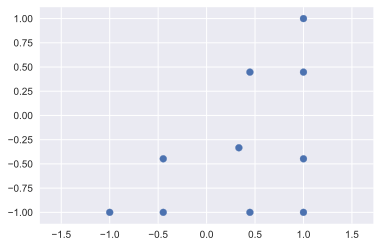

In [6]:
fig, ax = plt.subplots()
plt.scatter(mt.nodal_pts[:,0], mt.nodal_pts[:,1])
ax.axis('equal')
plt.show()

We can run the following benchmarking code (expensive), and generate a plot of wallclock time for master element initialization.

```python
master_init_times = []
for p in range(1, 11):
    start = time.clock()
    master_obj = mkm.Master_nodal(order=p, dim=2, element=0)
    end = time.clock()
    elapsed = end - start
    master_init_times.append(elapsed)
```

from which we plot
<img src="img/MPU_master_tri_init_times.png" alt="drawing" style="width: 500px;"/>

this is really slow. If we would like to play with higher order elements, we need a more efficient way of initializing these master elements.

# 2D nodal bases

## nodal basis over a triangle

### barycentric coordinate tools

In order to position points on the triangle, it will be convenient to work in [Barycentric coordinates](https://en.wikipedia.org/wiki/Barycentric_coordinate_system).
The following define the transformation to and from barycentric coordinates from cartesian coords.

In [7]:
# %load -s cart2bary,bary2cart ../src/fem_base/master/barycentric_coord_tools.py
def cart2bary(verts, pts):
    """ retrns barycentric coords of pt on a tri w/ vertices verts
    @param verts tuple of tuples specifying verts
    @param pt  numpy array of point on triangle shape (2, npts)
    """
    npts = pts.shape[1]
    _lambda = np.zeros((3, npts))
    (x1, y1), (x2, y2), (x3, y3) = verts
    T = np.array([[x1 - x3, x2 - x3],
                  [y1 - y3, y2 - y3]])
    r = np.copy(pts)
    r[0,:] -= x3
    r[1,:] -= y3

    _lambda[:2, :] = np.linalg.solve(T, r)
    _lambda[2, :] = 1 - _lambda[0,:] - _lambda[1,:]
    return _lambda

def bary2cart(verts, _lambda):
    """converts from barycentric to cartesian coordinates
    @param verts  tuple of tuples specifying triangle vertices
    @param _lambda array of barycentric points (3, npts)
    """
    npts = _lambda.shape[1]
    λ1, λ2, λ3 = _lambda[0,:], _lambda[1,:], _lambda[2,:]
    x, y = np.zeros(npts), np.zeros(npts)
    (x1, y1), (x2, y2), (x3, y3) = verts
    x = λ1*x1 + λ2*x2 + λ3*x3
    y = λ1*y1 + λ2*y2 + λ3*y3
    return x, y


The following generates the barycentric coordinates corresponding to uniform nodes on a triangle for a polynomial order $p$.

In [8]:
# %load -s uniform_bary_coords ../src/fem_base/master/barycentric_coord_tools.py
def uniform_bary_coords(p):
    """ generate bary coords of uniform nodal pts for tri of order p"""
    N, Np = p, int((p+1)*(p+2)/2)
    node = 0
    bary = np.zeros((3, Np))
    for i in range(N+1):
        for j in range(N+1-i):
            λ1, λ2 = i/N, j/N
            λ3 = 1 - λ1 - λ2
            bary[:, node] = np.asarray([λ1, λ2, λ3])
            node += 1
    return bary


In [9]:
# serves as a view mesh for the shape functions we are about to create
p = 24
Np = int((p+1)*(p+2)/2)
bary = uniform_bary_coords(p)
verts = ((-1, -1), (-1, 1), (1, -1))
x, y = bary2cart(verts, bary)

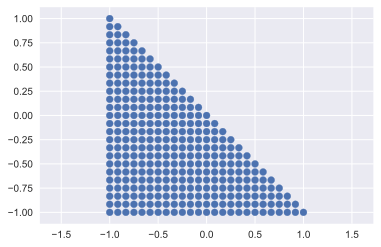

In [10]:
plt.scatter(x, y)
plt.axis('equal')
plt.show()

### generating the underlying polynomial modal basis

We need a way to generalize the 1D orthonormal polynomial basis to that over the standard simplex

$$T \equiv \{\mathbf{r}=(\xi, \eta) \mid (\xi, \eta) \leq -1; \xi+\eta \leq0\}$$

such that we can efficiently compute $\psi_m(\mathbf{r})$ over $T$. In Hesthaven and Warburton, the suggestion is to use the basis defined by

\begin{align}
   m(i,j) &= j + (N+1)i + 1 - \frac{i}{2}(i-1) \\
   \psi_m(\mathbf{r}) &= \sqrt{2} P_i(a) \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \\
   &a = 2 \frac{1+\xi}{1-\eta} - 1, b=\eta
\end{align}

Where $P_n^{(\alpha, \beta)}$(x) is the familiar $n^{th}$ order Jacobi polynomial over [-1, 1] discussed in depth in the `1D_basis_and_master` tutorial. We leverage `orthopy` in order to generate these polynomials over barycentric coordinates, and supply the master element vertices to create the basis over $T$. However, we will need these relations in order to compute the derivatives of the shape functions.

In [11]:
# %load ../src/fem_base/master/polynomials_2D.py
#!/usr/bin/env python

import numpy as np
import orthopy

import src.fem_base.master.barycentric_coord_tools as bct
from src.fem_base.master.master_2D import MASTER_ELEMENT_VERTICES

# define vertices on master elements as specified in master_2D.py
MASTER_TRI_VERTS = MASTER_ELEMENT_VERTICES['TRIANGLE']

def mk_m2ij(p):
    """ returns a list A for which A[m] = (i,j) for orthopy polynomials psi_m"""
    return [(j,i) for i in range(p) for j in range(i+1)]

def ortho_triangle(bary, p):
    """ wraps orthopy, returns tree of orthonormal polys over bary coords
    @param bary  barycentric points on a triangle at which to eval polynomials
    @param p  the order of the basis -- how many polynomials we want
    @retval polys (npts, m) array of psi_m at the npts

    orthopy returns a list of arrays, where `out[k]` hosts the `2*k+1`
    values of the `k`th level of the tree
        (0, 0)
        (0, 1)   (1, 1)
        (0, 2)   (1, 2)   (2, 2)
          ...      ...      ...   (i, j)
    so we unpack the (i,j) into the index m via m2ij above.
    """
    m2ij = mk_m2ij(p)
    ortho_output = orthopy.triangle.tree(bary, n=p, standardization='normal')
    npts, npolys = bary.shape[1], len(m2ij)
    polys = np.zeros((npts, npolys))
    for m, (i,j) in enumerate(m2ij):
        polys[:,m] = ortho_output[j][i,:]
    return polys

def P_tilde(pts, p, verts=MASTER_TRI_VERTS):
    """ generates the values of the orthonormal modal polynomials at pts r on the reference tri
    @param verts  tuple of tuples specifying the CCW vertices of the triangle in question
    @param pts  points defined on the triangle defd by verts (npts, 2)
    @param p  order of the orthonormal polynomial basis to be generated
    """
    bary_coords = bct.cart2bary(verts, pts.T)
    polys = ortho_triangle(bary_coords, p+1)
    return polys


In [12]:
xy = np.vstack((x, y)).T
xy.shape
pp = P_tilde(xy, p)
print(p)
pp.shape, x.shape

24


((325, 325), (325,))

need a good way of drawing the polys and the shape functions over the reference triangle

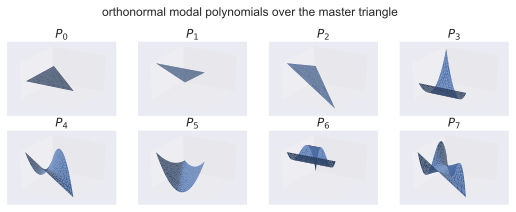

In [13]:
fig = plt.figure(figsize=(9, 3))
tri = mtri.Triangulation(x, y)
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    cax = ax.plot_trisurf(tri, pp[:,i], shade=True)
    ax.set_title(r'$P_{}$'.format(i), y=1.06)
fig.suptitle('orthonormal modal polynomials over the master triangle', y=1.04)
plt.show()

### nodal shape functions

Hesthaven makes the claim that $V^T \mathbf{\ell}(r) = \tilde{\mathbf{P}}(r)$. Just as we did when creating the 1D nodal shape functions, we can directly apply the relation

$$\ell = (V^T)^{-1} \tilde{\mathbf{P}}$$

which allows us to create our nodal shape functions from the orthonormal modal polynomial coefficients. 

In [14]:
p = 2
Np = int((p+1)*(p+2)/2)
bary = uniform_bary_coords(p)
verts = ((-1, -1), (-1, 1), (1, -1))
xp, yp = bary2cart(verts, bary)
xy = np.vstack((xp, yp)).T
V2D = P_tilde(xy, p)
print('shape of Vandermonde matrix: {}'.format(V2D.shape))
Ptil = pp[:,0:6]
print('shape of P_tilde: {}'.format(Ptil.shape))
Vti = np.linalg.inv(V2D.T)
yy = np.dot(Vti, Ptil.T)
yy.shape

shape of Vandermonde matrix: (6, 6)
shape of P_tilde: (325, 6)


(6, 325)

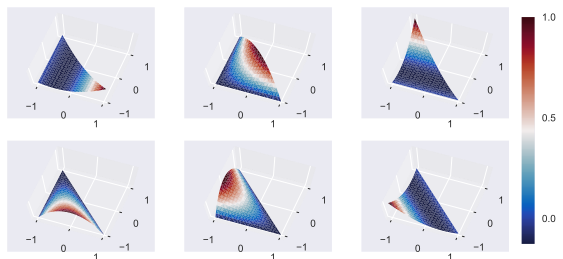

In [15]:
fig = plt.figure(figsize=(9, 4.5))
data = yy[4,:]

nb = yy.shape[0]
tri = mtri.Triangulation(x, y)
for i in range(nb):
    data = yy[i,:]
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.set_xticks([-1, 0, 1]); ax.set_yticks([-1,0,1]); ax.set_zticks([]);
    cax = ax.plot_trisurf(tri, data, cmap=cmo.cm.balance)
    ax.view_init(elev=75, azim=-70)
fig = mplu.add_shared_colorbar(fig, data, cmo.cm.balance, ticks=[0,0.5,1])
plt.show()

honestly, a height plot isn't really the best way to show this. It's a bit funny. Probably need to get `cairo` `mpl` backend working and do flat plots with shading.

### shape function derivatives

\begin{align}
   m(i,j) &= j + (N+1)i + 1 - \frac{i}{2}(i-1) \\
   \psi_m(\mathbf{r}) &= \sqrt{2} P_i(a) \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \\
   &a = 2 \frac{1+\xi}{1-\eta} - 1, b=\eta
\end{align}

So naturally
<img src="img/master_tri_func_dependence.png" alt="drawing" style="width: 250px;"/>
and the chain rule suggests that

\begin{align}
  \frac{d\psi_m}{d\xi} &= \frac{\partial a}{\partial\xi}\frac{\partial\psi_m}{\partial a} 
  = \frac{2}{1 - \eta}\frac{\partial\psi_m}{\partial a} 
  = \frac{2}{1 - b} \cdot \sqrt{2} \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \frac{\partial}{\partial a}\left( P_i(a)  \right) \\
    &= 2(1-b)^{i-1}\cdot \sqrt{2} \, P_j^{(2i+1, 0)}(b)\,\frac{\partial}{\partial a}\left( P_i(a)  \right)
  \end{align}
  
  
  \begin{align}
  \frac{d\psi_m}{d\eta} &= \frac{\partial a}{\partial \eta}\frac{\partial \psi_m}{\partial a} + \frac{db}{d\eta}\frac{d\psi_m}{db}
  = \frac{2(1+\xi)}{(1-\eta)^2}\frac{\partial \psi_m}{\partial a} + \frac{d\psi_m}{db} \\
  &= \frac{2(1+\xi)}{(1-\eta)^2}\sqrt{2} \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \frac{\partial}{\partial a}( P_i(a)  ) + \sqrt{2} \,P_i(a)\frac{\partial}{db}\left((1-b)^i\,P_j^{(2i+1, 0)}(b)\right) \\
%    &= \frac{2(1+\xi)}{(1-\eta)^2}\sqrt{2} \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \frac{\partial}{\partial a}( P_i(a)  ) + \sqrt{2} \,P_i(a)\left[(1-b)^i\,\frac{\partial}{db}\left(P_j^{(2i+1, 0)}(b)\right) + P_j^{(2i+1, 0)}(b)\left(i(1-b)^{i-1}\right)\right] \\
\end{align}

We follow Hesthaven's simplified and normalized expression which is equivalent to the above.

In [16]:
def xi_eta_to_ab(ξ, η):
    """ function to transform xi, eta coords to a, b
    see Hesthaven function 'rstoab'
    @param xi, eta vectors of xi, eta pts
    """
    a, b = np.zeros_like(ξ), np.zeros_like(η)
    singular = np.isclose(η, 1.0)
    nonsingular = np.logical_not(singular)
    a[nonsingular] = 2*(1. + ξ[nonsingular])/(1 - η[nonsingular]) - 1
    a[singular] = -1
    b = η
    return a, b

In [17]:
def poly_gradient_simplex(a, b, i, j):
    """ takes derivatives of modal basis polys w/r/t ξ, η 
    transcribed from GradSimplex2D in Hesthaven
    """
    Pa, dP_da = Jacobi_Poly(a,0,    0,i)[-1], Jacobi_Poly_Derivative(a,0    ,0,i)[-1]
    Pb, dP_db = Jacobi_Poly(b,2*i+1,0,j)[-1], Jacobi_Poly_Derivative(b,2*i+1,0,j)[-1]
    
    # d/dξ = da/dξ * d/da + db/dξ * d/db = 2/(1-b) d/da
    dψ_dξ = dP_da * Pb
    if i > 0:
        dψ_dξ *= ( (0.5*(1-b))**(i-1) )
    
    # d/dη = ((1+a)/2)/((1-b)/2)d/da + d/db
    dψ_dη = dP_da * (Pb * 0.5*(1+a))
    if i > 0:
        dψ_dη *= ((0.5*(1-b))**(i-1))
        
    tmp = dP_db * (0.5*(1-b))**(i)
    if i > 0:
        tmp -= 0.5*i*Pb * (0.5*(1-b))**(i-1)
    dψ_dη += Pa * tmp
    
    # normalize both derivatives
    dψ_dξ *= 2**(i+0.5)
    dψ_dη *= 2**(i+0.5)
    
    return [dψ_dξ, dψ_dη]

In [18]:
def GradVandermonde2D(p, ξ, η):
    """ compute the derivative vandermonde matrices in ξ, η directions """
    Np = int((p+1)*(p+2)/2)
    npts = len(ξ)
    a, b = xi_eta_to_ab(ξ, η)
    dVξ, dVη = np.zeros((npts, Np)), np.zeros((npts, Np))
    counter = 0
    for i in range(p+1):
        for j in range(p-i+1):
            dψ_dξ, dψ_dη = poly_gradient_simplex(a, b, i, j)
            dVξ[:,counter] = dψ_dξ
            dVη[:,counter] = dψ_dη
            counter += 1
    return [dVξ, dVη]

In [19]:
gv = GradVandermonde2D(p,x,y)
#a, b = xi_eta_to_ab(x, y)
V2D.shape
gv[0].shape
Vti = np.linalg.inv(V2D)
Dr = np.dot(gv[0], Vti)

there will be an issue with the indexing of the polynomials and derivatives. Will need to define convenience functions which actually give the i, j th order poly and that's all.

Additionally, need to check that derivative of first poly is 0, next two are constant, third is linear etc.

### warping and blending

All of the developments so far have been agnostic to choice of where the nodal points were placed, but (as in 1D), the equally spaced points are not optimal for interpolation and are susceptible to Runge phenomenon. In this section, we consider a method by which we can perturb the nodal points for good interpolation behavior.

the warping function is quantity defined over the 1D master element [-1, 1] as 

\begin{align}
    \tilde{w}(r) \equiv \frac{ \sum_{i=1}^{N_p} (r_i^{LGL} - r_i^{eq})\phi^{eq}_i(r)}{1 - r^2}
\end{align}

where $r_i^{LGL},\, r_i^{eq}$ are the $i^{th}$ LegendreGaussLobatto and equally spaced points, respectively, and $\phi_i^{eq}$ are the nodal 1D shape functions defined over the equally spaced points $r_i^{eq}$.

In [156]:
def _w_tilde(p, pts):
    """ evaluate 1D warp factor w_tilde at order N at pts """
    nb1d = NB1D.NodalBasis1D(p=p, node_spacing='EQUIDISTANT')
    shap = nb1d.shape_functions_at_pts(pts)
    
    r_eq = nb1d.nodal_pts
    r_LGL, _ = NB1D.LegendreGaussLobatto(nb1d.nb)

    numerator = np.dot(shap, r_LGL - r_eq)
    denom = 1 - pts**2
    denom[np.isclose(denom, 0.)] = 1  # don't divide by zero, numerator 0 here
    wr = numerator / denom
    return wr

def mk_warped_nodes(p, α=0.):
    """ compute warped nodal points on the order p master triangle 
    NOTE: Hesthaven uses scaled barycentric coords, so we transcribe 
        Nodes2D.m, xytors.m directly rather than rescale things. This is done 
        for readability in comparison to the Hesthaven text.
    """
    λ1, λ2, λ3 = bct.uniform_bary_coords(p)
    x, y = -λ2 + λ3, (-λ2 - λ3 + 2*λ1) / np.sqrt(3) 
    
    # warping and blending functions
    wt1, wt2, wt3 = _w_tilde(p, λ3-λ2), 0.5*_w_tilde(p, λ1-λ3), 0.5*_w_tilde(p,λ2-λ1)
    b1, b2, b3 = 4*λ3*λ2, 4*λ3*λ1, 4*λ2*λ1
    w1, w2, w3 = wt1*b1*(1+(α*λ1)**2), wt2*b2*(1+(α*λ2)**2), wt3*b3*(1+(α*λ3)**2)
    
    # move the cartesian points on the equilateral triangle
    x += (1)*w1 + (-1)        *w2 + (-1)         *w3
    y += (0)*w1 + (np.sqrt(3))*w2 + (-np.sqrt(3))*w3
    
    # map back to master element from equilateral triangle
    λ1, λ2, λ3 = (np.sqrt(3)*y+1)/3, (-3*x-np.sqrt(3)*y+2)/6, (3*x-np.sqrt(3)*y+2)/6
    r, s = -λ2 + λ3 - λ1, -λ2 -λ3 + λ1
    return r, s

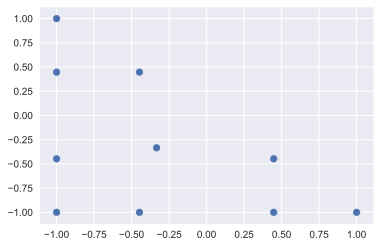

In [157]:
wx, wy = mk_warped_nodes(p=3)
#plt.scatter(x, y)
plt.scatter(wx, wy)



### `NodalBasis2DTriangle`

In [20]:
import src.fem_base.master.nodal_basis_2D as NB2D

In [21]:
nbp3 = NB2D.NodalBasis2DTriangle(p=3)
nbp30 = NB2D.NodalBasis2DTriangle(p=30)
view_pts = nbp30.nodal_pts
print(view_pts.shape)
shap = nbp3.shape_functions_at_pts(view_pts)

(496, 2)


In [22]:
x, y = view_pts.T
nb = nbp3.nb
# draw nodal points, view pts

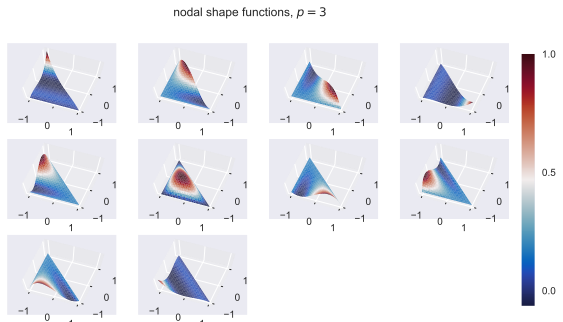

In [23]:
tri = mtri.Triangulation(x, y)
fig = plt.figure(figsize=(9, 5))
for i in range(nb):
    data = shap[i,:]
    ax = fig.add_subplot(3, 4, i+1, projection='3d')
    ax.set_xticks([-1, 0, 1]); ax.set_yticks([-1,0,1]); ax.set_zticks([]);
    cax = ax.plot_trisurf(tri, data, cmap=cmo.cm.balance)
    ax.view_init(elev=75, azim=-70)
fig = mplu.add_shared_colorbar(fig, data, cmo.cm.balance, ticks=[0,0.5,1])
fig.suptitle(r'nodal shape functions, $p = {}$'.format(nbp3.p))
plt.show()

TODO:

- warping and blending ripped from defunct files

## nodal basis over a quadrilateral

# 2D master elements

## master triangle

 - access quadrature points from the MPU cubature files -- cannibalize

## master quadrilateral

# TODO

- unit test where we transform from bary 2 cart 2 bary again
- unit test where we integrate the polys and recover the identity matrix
- unit test where we check Lesbesgue constant and compare to Hesthaven's